**Постановка задачи**

Эта программа реализует систему рекомендаций, в которой используются данные о намерениях и интересах пользователей сервиса сканирования для сбора контактов.

***User story:*** в качестве стартегического развития текущей рекомендательной системы, обучить модель на данных лидсканирования(собранных лидов) для упролщенного поиска похожих пользователей на профиль отсканированных посетителей и продолжения взаимодействия после выставки на веб плтаформе.



**Реализация**

Первым этапом идет загрузка и очистка данных из CSV-файла. Затем категориальные данные о намерениях и интересах преобразуются в числовой формат с помощью векторизации.
С помощью метода локтя определяются оптимальные группы пользователей (кластеры) с использованием алгоритма KMeans. Также обучаются модели KNN для поиска ближайших соседей и Random Forest для предсказания намерений и интересов пользователей.
Наконец, разрабатываются функции для генерации рекомендаций на основе уникальных идентификаторов пользователей, исключая дубликаты. Весь процесс обеспечивает эффективный анализ взаимодействия пользователей друг с другом и создание персонализированных рекомендаций.


В процессе решения задачи бизнесс кейс был изменен, поэтому все решение подразделяется на два блока:

**Первый блок** кода ставит цель векторизовать текстовые данные о намерениях и интересах, чтобы использовать их позже для моделей.

**Второй блок** кода четко определяет предсказательную задачу классификации, обучая модель на основе меток совпадений интересов и проводя ее оценку. Этот блок включает векторизацию в контексте задачи классификации и ориентирован на разработку рабочего классификатора, способного выполнять предсказания.

In [93]:
import pandas as pd
import numpy as np
import uuid

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

###Загрузка и предобработка данных:
Загрузка данных из CSV файла и назначение новых названий столбцов. Удаление первой строки, возможно, содержащей не нужную информацию. Присвоение уникальных идентификаторов email и компаний, чтобы система могла отслеживать их уникальность.

In [108]:
# Загрузка данных
data = pd.read_csv('/content/AT_User_Scans.csv', delimiter =';')  # Укажите путь к вашему файлу

# Шаг 2: Просмотр текущих названий столбцов
print("Старые названия столбцов:")
print(data.columns)

Старые названия столбцов:
Index(['Unnamed: 0', 'Scanned by', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Was Scanned',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [109]:
# Установка названий столбцов
data.columns = ['Scan_date', 'Email_scanned_by', 'First Name_scanned_by', 'Last Name_scanned_by',
                'User  Type_scanned_by', 'Company_scanned_by', 'Job role_scanned_by',
                'Intents_scanned_by', 'Interests_scanned_by', 'Email_was_scanned',
                'First Name_was_scanned', 'Last Name_was_scanned', 'User  Type_was_scanned',
                'Company_was_scanned', 'Job role_was_scanned', 'Intents_was_scanned',
                'Interests_was_scanned']

In [110]:
# Удаляем строку с индексом 0
data = data.drop(index=0)

Проставление id для посетителей

In [111]:
#Создание словаря для маппинга
email_to_uuid = {}

#Присвоение уникального UUID каждому email
def get_or_create_uuid(email):
    if email not in email_to_uuid:
        # Если email еще не в словаре, создаем новый UUID и добавляем в словарь
        email_to_uuid[email] = str(uuid.uuid4())
    return email_to_uuid[email]

# Применяем функцию к каждому email
data['id_was_scanned'] = data['Email_was_scanned'].apply(get_or_create_uuid)

Проставление id для участников

In [112]:
# Создание уникального списка компаний
unique_companies = data['Company_scanned_by'].unique()

# Создание маппинга уникальных компаний на уникальные id
company_to_id = {company: idx for idx, company in enumerate(unique_companies, start=4500)}

# Добавление уникального ID для компаний
data['company_id'] = data['Company_scanned_by'].map(company_to_id)

#Создание маппинга для email
email_to_company_id = {}
for index, row in data.iterrows():
    email_to_company_id[row['Email_scanned_by']] = data.at[index, 'company_id']

# Присвоение идентификаторов email на основе их компании
data['id_scanned_by'] = data['Email_scanned_by'].map(email_to_company_id)

###Очистка данных и фильтрация:
Удаление строк с определенными ненужными значениями в столбцах.
Удаление строк с пропущенными значениями в определенных столбцах.
Сохранение очищенных данных в новый CSV файл.

In [113]:
# Выбор только необходимых колонок
data = data[['Scan_date', 'id_scanned_by','Email_scanned_by', 'First Name_scanned_by', 'Last Name_scanned_by',
                'User  Type_scanned_by', 'Company_scanned_by', 'Job role_scanned_by',
                'Intents_scanned_by', 'Interests_scanned_by', 'id_was_scanned','Email_was_scanned',
                'First Name_was_scanned', 'Last Name_was_scanned', 'User  Type_was_scanned',
                'Company_was_scanned', 'Job role_was_scanned', 'Intents_was_scanned',
                'Interests_was_scanned']]

In [114]:
# Или удалить строки с пропусками
data.dropna(subset=['Intents_scanned_by', 'Interests_scanned_by', 'Intents_was_scanned', 'Interests_was_scanned'], inplace=True)

In [115]:
# Удаляем строки, где 'User  Type_scanned_by' равно ненужному значению
unwanted_values = ['Посетитель', 'Организатор']
data = data[~data['User  Type_scanned_by'].isin(unwanted_values)]

unwanted_values = ['Участник Aquatherm', 'Организатор']
data = data[~data['User  Type_was_scanned'].isin(unwanted_values)]

In [116]:
data=data.drop(columns=['Scan_date', 'Email_scanned_by', 'First Name_scanned_by', 'Last Name_scanned_by',
                'User  Type_scanned_by', 'Company_scanned_by', 'Job role_scanned_by','Email_was_scanned',
                'First Name_was_scanned', 'Last Name_was_scanned', 'User  Type_was_scanned',
                'Company_was_scanned', 'Job role_was_scanned'])

In [11]:
# Сохраняем данные в новый файл
data.to_csv('new_clean_data.csv', index=False)

### Работа с новым файлом. Подготовка данных для анализа:
Использование TF-IDF векторизации для преобразования текстовой информации о намерениях и интересах пользователей в численный формат.
Создание объединенных строк для сканируемых и сканирующих пользователей, чтобы использовать их в дальнейшем анализе.

In [163]:
# Загрузка данных
data = pd.read_csv('/content/new_clean_data.csv')  # Укажите путь к вашему файлу

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10586 entries, 0 to 10585
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_scanned_by          10586 non-null  int64 
 1   Intents_scanned_by     10586 non-null  object
 2   Interests_scanned_by   10586 non-null  object
 3   id_was_scanned         10586 non-null  object
 4   Intents_was_scanned    10586 non-null  object
 5   Interests_was_scanned  10586 non-null  object
dtypes: int64(1), object(5)
memory usage: 496.3+ KB


In [151]:
data

,id_scanned_by,Intents_scanned_by,Interests_scanned_by,id_was_scanned,Intents_was_scanned,Interests_was_scanned
0,4502,найти партнеров,Производство,ad115112-245d-4806-9ee3-e81c7caf6dd7,Получение общей отраслевой информации,"Отопительное оборудование, Оборудование для во..."
1,4505,"узнать новости отрасли, найти клиентов, узнать...","КИП и системы автоматизации, Маркетинг, Продаж...",72ab26e9-783d-43eb-8b0c-61c6f9331ba1,Продвижение собственных товаров и услуг,"Отопительное оборудование, Оборудование для во..."
2,4506,Личные интересы,"Отопительное оборудование, Трубы, фитинги, арм...",72ab26e9-783d-43eb-8b0c-61c6f9331ba1,Продвижение собственных товаров и услуг,"Отопительное оборудование, Оборудование для во..."
3,4507,Продвижение собственных товаров и услуг,"Трубы, фитинги, арматура",bf0988df-9d2f-49f4-8084-1762ded510ac,Поиск продукции или услуг для бизнеса,"Трубы, фитинги, арматура, Приборы контроля, из..."
4,4509,продвижение продуктов,Продажи,7c1bde01-1936-4edd-a9f3-e92fc8e946e4,Поиск продукции или услуг для бизнеса,"Вентиляционное оборудование, Оборудование для ..."
...,...,...,...,...,...,...
10581,5709,"узнать новости отрасли, узнать тренды и аналит...","Продажи, Оборудование для водоснабжения, Произ...",dd5a00b2-8ed2-4667-b20b-5a28c2249f56,Получение общей отраслевой информации,"Отопительное оборудование, Оборудование для во..."
10582,5711,"найти клиентов, продвижение продуктов, найти п...",Производство,8ab38b49-42f2-4bb7-8eb0-ed9efc366e96,Поиск продукции или услуг для бизнеса,"Системы контроля качества воздуха, Инструменты..."
10583,5711,"найти клиентов, продвижение продуктов, найти п...",Производство,eace1ff0-2c9d-45c8-975c-23dd104859bb,Поиск продукции или услуг для бизнеса,"Отопительное оборудование, Инструменты для мон..."
10584,5711,"найти клиентов, продвижение продуктов, найти п...",Производство,38d0cca4-f1e0-44b5-a127-105da35d0f8f,Получение общей отраслевой информации,"Бассейны, велнес-центры, бани и СПА, Трубы, фи..."


In [120]:
def split_values(column):
    return column.str.split(',').apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else [])

data['Intents_scanned_by'] = split_values(data['Intents_scanned_by'])
data['Interests_scanned_by'] = split_values(data['Interests_scanned_by'])
data['Intents_was_scanned'] = split_values(data['Intents_was_scanned'])
data['Interests_was_scanned'] = split_values(data['Interests_was_scanned'])

In [ ]:
data

,id_scanned_by,Intents_scanned_by,Interests_scanned_by,id_was_scanned,Intents_was_scanned,Interests_was_scanned
0,4502,[найти партнеров],[Производство],1d16defa-4894-4965-88a5-59f5d19d4a3b,[Получение общей отраслевой информации],"[Отопительное оборудование, Оборудование для в..."
1,4505,"[узнать новости отрасли, найти клиентов, узнат...","[КИП и системы автоматизации, Маркетинг, Прода...",08505769-0c5f-45b1-9881-26057d96bb2c,[Продвижение собственных товаров и услуг],"[Отопительное оборудование, Оборудование для в..."
2,4506,[Личные интересы],"[Отопительное оборудование, Трубы, фитинги, ар...",08505769-0c5f-45b1-9881-26057d96bb2c,[Продвижение собственных товаров и услуг],"[Отопительное оборудование, Оборудование для в..."
3,4507,[Продвижение собственных товаров и услуг],"[Трубы, фитинги, арматура]",81ffb112-fd34-4bb5-bcca-f830004641f5,[Поиск продукции или услуг для бизнеса],"[Трубы, фитинги, арматура, Приборы контроля, и..."
4,4509,[продвижение продуктов],[Продажи],e64714ea-06e8-46c6-a0ef-3b5b6f73a6e1,[Поиск продукции или услуг для бизнеса],"[Вентиляционное оборудование, Оборудование для..."
...,...,...,...,...,...,...
3422,4702,[Личные интересы],"[Отопительное оборудование, Оборудование для в...",12e89ef4-188e-4b6e-9733-88e3bddbf12d,[Поиск продукции или услуг для бизнеса],"[Отопительное оборудование, Оборудование для в..."
3423,4512,[найти продукт],"[Бассейны, оборудование для бассейнов и бань, ...",72c6ff71-2666-4e23-9fe7-dd6effe05eb7,[Поиск продукции или услуг для бизнеса],"[Бассейны, велнес-центры, бани и СПА, Трубы, ф..."
3424,4706,[Образовательные цели],"[Водонагреватели, Отопительное оборудование]",43e4702f-779a-4684-8a94-c276c1530c8a,[Получение общей отраслевой информации],"[Отопительное оборудование, Оборудование для в..."
3425,4502,"[найти клиентов, повысить узнаваемость компании]",[Инженерные системы для водоснабжения и отопле...,43e4702f-779a-4684-8a94-c276c1530c8a,[Получение общей отраслевой информации],"[Отопительное оборудование, Оборудование для в..."


## Первый блок кода
Создание колонок с объединенными интересами и намерениями:
* Создается новая колонка combined_scanned, в которой объединяются
текстовые данные о намерениях и интересах
* Применяется TfidfVectorizer для получения матрицы признаков X_scanned.
Векторизация для второй категории
* Создается колонка combined_was и применяется векторизация с использованием готового vectorizer.

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Создать колонку с объединенными интересами и намерениями
data['combined_scanned'] = data['Intents_scanned_by'].apply(lambda x: ' '.join(x)) + ' ' + data['Interests_scanned_by'].apply(lambda x: ' '.join(x))

# Применение TF-IDF
vectorizer = TfidfVectorizer()
X_scanned = vectorizer.fit_transform(data['combined_scanned'])

# Аналогично для второй категории
data['combined_was'] = data['Intents_was_scanned'].apply(lambda x: ' '.join(x)) + ' ' + data['Interests_was_scanned'].apply(lambda x: ' '.join(x))
X_was = vectorizer.transform(data['combined_was'])

###Кластеризация и обучение модели KNN:
Применение метода локтя для определения оптимального количества кластеров в KMeans.
Обучение модели KNN для поиска ближайших соседей на основе TF-IDF представлений.

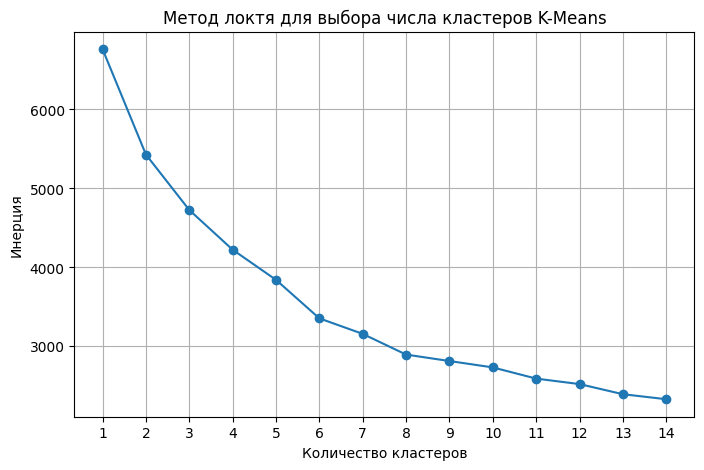

In [122]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Шаг 2: Выбор числа кластеров
# Используем метод локтя
inertia = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_was)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Метод локтя для выбора числа кластеров K-Means')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.xticks(k_values)
plt.grid()
plt.show()

In [123]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scanned, X_was, test_size=0.2, random_state=42)

# Обучение модели Nearest Neighbors
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_train)

# Поиск ближайших соседей
distances, indices = knn.kneighbors(X_test)


In [124]:
# Обучение модели KNN
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
knn_model.fit(X_was)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [125]:
pca = PCA(n_components=2) # Указываем, что хотим 2 главных компоненты
X_was_pca = pca.fit_transform(X_was.toarray()) # пересчитываем в array, чтобы PCA работал

###Визуализация данных:
Использование PCA для уменьшения размерности и визуализации текстовых данных.

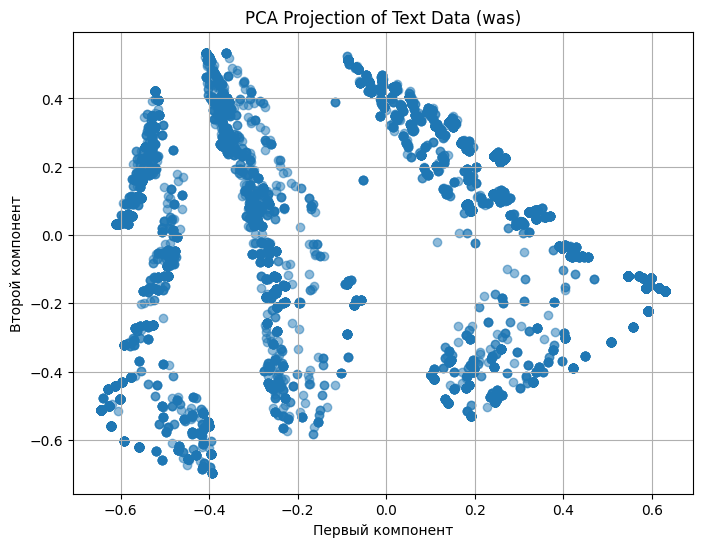

In [126]:
#Визуализируем результаты
plt.figure(figsize=(8, 6))
plt.scatter(X_was_pca[:, 0], X_was_pca[:, 1], alpha=0.5)
plt.title('PCA Projection of Text Data (was)')
plt.xlabel('Первый компонент')
plt.ylabel('Второй компонент')
plt.grid()
plt.show()

###Функция рекомендации:
Создание функции get_recommendations, которая находит и предлагает рекомендации на основе идентификатора сканированного пользователя.
В функции учитываются уникальные рекомендации, игнорируя самого пользователя.

In [127]:
def get_recommendations(id_scanned_by):
    # Найти индекс пользователя по email
    index = data[data['id_scanned_by'] == id_scanned_by].index

    if not index.empty:
        user_vector = X_scanned[index][0]  # Получаем эмбеддинг пользователя
        distances, indices = knn_model.kneighbors(user_vector)

        # Извлекаем рекомендации, исключая самого себя
        recommendations = data.iloc[indices.flatten()]

        # Удаляем текущего пользователя из рекомендаций
        recommendations = recommendations[recommendations['id_was_scanned'] != id_scanned_by]

        # Удаляем дубликаты по email
        unique_recommendations = recommendations.drop_duplicates(subset='id_was_scanned')

        unique_recommendations = data.iloc[indices.flatten()]
        return unique_recommendations[['id_was_scanned', 'Intents_was_scanned', 'Interests_was_scanned']]

    return None

In [128]:
# Пример вызова функции
email_to_check = 4506  # Замените на email вашего пользователя
recommendations = get_recommendations(email_to_check)

if recommendations is not None and not recommendations.empty:
    print("Рекомендации для пользователя:", email_to_check)
    for index, row in recommendations.iterrows():
        print(f"id_visitor: {row['id_was_scanned']}, Intents: {row['Intents_was_scanned']}, Interests: {row['Interests_was_scanned']}")
else:
    print(f"Рекомендации для пользователя {email_to_check} не найдены.")

Рекомендации для пользователя: 4506
id_visitor: 1f9a3167-b065-42d4-ac2f-ffebb3047077, Intents: ['Личные интересы'], Interests: ['Отопительное оборудование', 'Трубы', 'фитинги', 'арматура']
id_visitor: 1d342286-f225-42b4-b0d9-494fbf2680b1, Intents: ['Личные интересы'], Interests: ['Отопительное оборудование', 'Трубы', 'фитинги', 'арматура']
id_visitor: 829678af-98e0-4e1b-94c8-3fe68cb15e45, Intents: ['Личные интересы'], Interests: ['Отопительное оборудование', 'Трубы', 'фитинги', 'арматура']
id_visitor: 40b2c9c1-a61e-4614-81ee-e08f73d09daf, Intents: ['Личные интересы'], Interests: ['Отопительное оборудование', 'Трубы', 'фитинги', 'арматура']
id_visitor: 4517fd2e-9838-40e5-a0c0-296e38b767a5, Intents: ['Личные интересы'], Interests: ['Отопительное оборудование', 'Трубы', 'фитинги', 'арматура']
id_visitor: 6aaf5d68-3551-4601-ba81-9935fefef318, Intents: ['Личные интересы'], Interests: ['Трубы', 'фитинги', 'арматура']


###Оценка моделей:
Использование классификационного отчета для оценки точности KNN.



In [129]:
# Получение предсказанных меток
predictions = []
for i in range(len(indices)):
    # Получаем индексы ближайших соседей для каждого примера в тестовой выборке
    neighbor_indices = indices[i]
    # Получаем векторные представления для ближайших соседей
    neighbor_labels = y_train[neighbor_indices].toarray()  # Преобразуем CSR-матрицу в массив

    # Суммируем метки соседей
    aggregated_labels = neighbor_labels.sum(axis=0)  # Суммируем по каждому классу
    most_common_label_index = np.argmax(aggregated_labels)  # Индекс наиболее частого метки
    predictions.append(most_common_label_index)

# Преобразуем y_test в аналогичную форму для сравнения
y_test_indices = np.array([np.argmax(row.toarray()) for row in y_test])  # Используем toarray()

# Оценка модели
print(classification_report(y_test_indices, predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        26
           3       0.02      0.01      0.01        97
           6       0.35      0.16      0.22       346
          11       0.23      0.42      0.29       449
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         3
          24       0.31      0.14      0.19       381
          26       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         3
          31       0.00      0.00      0.00         1
          34       0.13      0.07      0.10       258
          38       0.00      0.00      0.00         1
          39       0.02      0.02      0.02        65
          40       0.05      0.02      0.03       131
          45       0.00      0.00      0.00        30
          48       0.00      0.00      0.00         3
          52       0.31    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Random Forest

In [ ]:
# Предобработка данных
X = data[['Intents_scanned_by',
           'Interests_scanned_by']]

# Создание DataFrame для целевых переменных
y = data[['Intents_was_scanned', 'Interests_was_scanned']]

# Преобразовать списки в строки
def convert_lists_to_strings(value):
    if isinstance(value, list):
        return ', '.join(value)
    return str(value)  # Если не список, то просто преобразуем в строку.

# Функция к каждому столбцу, который может содержать списки
for col in X.columns:
    X[col] = X[col].apply(convert_lists_to_strings)

# Векторизация текстовых данных
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

<ipython-input-37-c0a8895f83c3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].apply(convert_lists_to_strings)


In [ ]:
# Обучение модели Random Forest для обоих целевых переменных
model_intents = RandomForestClassifier(n_estimators=10, random_state=42)
model_interests = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучение модели на целевой переменной `Intents_was_scanned`
model_intents.fit(X_train, y_train['Intents_was_scanned'])

# Обучение модели на целевой переменной `Interests_was_scanned`
model_interests.fit(X_train, y_train['Interests_was_scanned'])

# Предсказание на тестовой выборке
y_pred_intents = model_intents.predict(X_test)
y_pred_interests = model_interests.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_intents = accuracy_score(y_test['Intents_was_scanned'], y_pred_intents)
accuracy_interests = accuracy_score(y_test['Interests_was_scanned'], y_pred_interests)

print(f"Точность модели для Intents: {accuracy_intents * 100:.2f}%")

print(f"Точность модели для Interests: {accuracy_interests * 100:.2f}%")

Точность модели для Intents: 58.60%
Точность модели для Interests: 4.52%


In [ ]:
def recommend_similar_ids(input_id, data, model_intents, model_interests):
    # Получение входных данных из вашего DataFrame
    input_data = data[data['id_scanned_by'] == input_id]

    if input_data.empty:
        print("ID не найден.")
        return None

    # Предсказание намерений и интересов
    input_X = input_data[['Intents_scanned_by', 'Interests_scanned_by']]
    input_X_encoded = encoder.transform(input_X)

    predicted_intents = model_intents.predict(input_X_encoded)
    predicted_interests = model_interests.predict(input_X_encoded)

    # Добавление предсказанных намерений и интересов в DataFrame
    input_data['Predicted_Intent'] = predicted_intents
    input_data['Predicted_Interest'] = predicted_interests

    # Фильтрация данных, чтобы получить похожие id
    recommendations = data[(data['Intents_was_scanned'] == predicted_intents[0]) |
                           (data['Interests_was_scanned'] == predicted_interests[0])]

    return recommendations[['id_was_scanned', 'Intents_was_scanned', 'Interests_was_scanned']].drop_duplicates()

In [ ]:
# Пример использования
recommended_items = recommend_similar_ids(4502, data, model_intents, model_interests)
print(recommended_items)

                            id_was_scanned  \
3     81ffb112-fd34-4bb5-bcca-f830004641f5   
4     e64714ea-06e8-46c6-a0ef-3b5b6f73a6e1   
5     de244e64-99af-4e37-9fa1-2aaba7b56bc2   
10    c754912c-bdcb-4289-92cf-8d561204a57d   
14    e3f59abd-7f01-4062-8ea0-a7c18dcc09dc   
...                                    ...   
3416  99801373-5b83-4ad2-aff2-37d39bd7e4cd   
3417  e681c986-4162-43fb-9275-d6f521b509e2   
3419  54db66df-c380-4589-a447-1d40cb1be673   
3421  12e89ef4-188e-4b6e-9733-88e3bddbf12d   
3423  72c6ff71-2666-4e23-9fe7-dd6effe05eb7   

                        Intents_was_scanned  \
3     Поиск продукции или услуг для бизнеса   
4     Поиск продукции или услуг для бизнеса   
5     Поиск продукции или услуг для бизнеса   
10    Поиск продукции или услуг для бизнеса   
14    Поиск продукции или услуг для бизнеса   
...                                     ...   
3416  Поиск продукции или услуг для бизнеса   
3417  Поиск продукции или услуг для бизнеса   
3419  Поиск продукции ил

<ipython-input-42-4b40fdddcabb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Predicted_Intent'] = predicted_intents
<ipython-input-42-4b40fdddcabb>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data['Predicted_Interest'] = predicted_interests


## Второй блок кода
Создание обучающей выборки и меток:
* Создаются список пар данных data_pairs, состоящих из интересов компании и посетителя.
* Для каждой пары определяется, есть ли совпадения интересов, что приводит к созданию меток (1 для совпадений и 0 для их отсутствия).

Векторизация:
* Используется TfidfVectorizer для преобразования пар данных в числовой формат.

###Реализация логистической регрессии:
Создание модели логистической регрессии для предсказания совпадений интересов между компаниями и посетителями.



In [132]:
# Создание обучающей выборки и меток
data_pairs = []
labels = []

for _, row in data.iterrows():
    interests_company = row['Interests_scanned_by']
    interests_visitor = row['Interests_was_scanned']

    data_pairs.append(interests_company + " | " + interests_visitor)

    # Определение совпадения интересов
    if set(interests_company.split(',')) & set(interests_visitor.split(',')):
        labels.append(1)  # Совпадение
    else:
        labels.append(0)  # Нет совпадения

# Преобразование текста в числовой формат
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_pairs)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Обучение модели
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1358
           1       0.66      0.69      0.67       760

    accuracy                           0.76      2118
   macro avg       0.74      0.74      0.74      2118
weighted avg       0.76      0.76      0.76      2118



###Функция рекомендаций на основе логистической регрессии:
Реализация функции get_recommendations_by_id, которая предоставляет рекомендации на основе идентификатора пользователя.

In [133]:
# Функция для получения рекомендаций по id_scanned_by
def get_recommendations_by_id(data, id_scanned_by, model, vectorizer):
    # Получаем данные по id_scanned_by
    company_row = data[data['id_scanned_by'] == id_scanned_by]
    if company_row.empty:
        return "ID не найден"
    # Получаем интересы компании
    interests_company = company_row['Interests_scanned_by'].values[0]

    # Делаем предсказания по всем остальным записям и генерируем рекомендации
    recommendations = []
    for _, row in data.iterrows():
        interests_visitor = row['Interests_was_scanned']
        pair = interests_company + " | " + interests_visitor
        prediction = model.predict(vectorizer.transform([pair]))
        if prediction[0] == 1:
            recommendations.append({
                'id_was_scanned': row['id_was_scanned'],
                'interests_was_scanned': row['Interests_was_scanned'],
                'intents_was_scanned': row['Intents_was_scanned']
            })
    return recommendations


In [83]:
# Получаем рекомендации по id_scanned_by
id_to_lookup = 4506  # ID для поиска рекомендаций
recommendations = get_recommendations_by_id(data, id_to_lookup, model, vectorizer)
# Проверяем, есть ли рекомендации, и выводим их
if recommendations:
    for rec in recommendations:
        print(rec)
else:
    print("Рекомендации не найдены.")

Streaming output truncated to the last 5000 lines.
{'id_was_scanned': '6f3dbba5-ef64-4fed-bc52-283c6b8cc925', 'interests_was_scanned': 'Отопительное оборудование, Оборудование для водоснабжения, Бассейны, велнес-центры, бани и СПА, Трубы, фитинги, арматура, Инструменты для монтажа, резки и сварки', 'intents_was_scanned': 'Получение общей отраслевой информации'}
{'id_was_scanned': '6f3dbba5-ef64-4fed-bc52-283c6b8cc925', 'interests_was_scanned': 'Отопительное оборудование, Оборудование для водоснабжения, Бассейны, велнес-центры, бани и СПА, Трубы, фитинги, арматура, Инструменты для монтажа, резки и сварки', 'intents_was_scanned': 'Получение общей отраслевой информации'}
{'id_was_scanned': '09db9f77-6723-4ec9-9966-275d38ff4e5a', 'interests_was_scanned': 'Инструменты для монтажа, резки и сварки', 'intents_was_scanned': 'Личные интересы'}
{'id_was_scanned': '5f6a19c0-ed7f-49a8-9243-c191bb9d4045', 'interests_was_scanned': 'Отопительное оборудование', 'intents_was_scanned': 'Личные интересы'}

###Улучшение KNN:
Оптимизация модели KNN на основе аналогичного принципа, который использовался ранее, с целью повышения предсказательной мощности.


In [164]:
data_pairs = []
labels = []
for _, row in data.iterrows():
    interests_company = row['Interests_scanned_by']
    interests_visitor = row['Interests_was_scanned']
    # Создание пары интересов
    data_pairs.append(interests_company + " | " + interests_visitor)
    # Проверка на наличие значений в столбцах
    if pd.notna(interests_company) and pd.notna(interests_visitor):
        # Определяем совпадения интересов
        company_interests_set = set(interests_company.split(','))
        visitor_interests_set = set(interests_visitor.split(','))
        if company_interests_set & visitor_interests_set:
            labels.append(1)  # Совпадение
        else:
            labels.append(0)  # Нет совпадения
    else:
        # Если одно из значений отсутствует, можно добавить метку, например, 0
        labels.append(0)

In [165]:
# Преобразование текста в числовой формат
new_vectorizer = TfidfVectorizer()
X = new_vectorizer.fit_transform(data_pairs)
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
# Обучение модели KNN
new_model = KNeighborsClassifier(n_neighbors=5)
new_model.fit(X_train, y_train)
# Оценка модели
y_pred = new_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1358
           1       0.77      0.78      0.78       760

    accuracy                           0.84      2118
   macro avg       0.82      0.83      0.82      2118
weighted avg       0.84      0.84      0.84      2118



###Получение уникальной информации о сканировании:
Реализация функции get_unique_scanned_info, которая возвращает уникальную информацию о пользователе на основе его идентификатора.

In [166]:
def get_recommendations(id_scanned_by):
    # Найти индекс пользователя по id_scanned_by
    index = data[data['id_scanned_by'] == id_scanned_by].index
    if not index.empty:
        user_vector = X[index][0]  # Получаем эмбеддинг пользователя на основе пар интересов
        distances, indices = new_model.kneighbors(user_vector, n_neighbors=5)  # Поиск ближайших соседей
        # Извлекаем рекомендации
        recommendations = data.iloc[indices.flatten()]
        # Удаляем текущего пользователя из рекомендаций
        recommendations = recommendations[recommendations['id_was_scanned'] != id_scanned_by]
        # Сохраняем только уникальные рекомендации
        unique_recommendations = recommendations.drop_duplicates(subset='id_was_scanned')
        # Выбираем нужные столбцы
        return unique_recommendations[['id_was_scanned', 'Intents_was_scanned', 'Interests_was_scanned']]
    return None

In [167]:
# Задайте идентификатор пользователя
user_id = 4512
# Вызовите функцию для получения рекомендаций
recommendations = get_recommendations(user_id)
# Печать рекомендаций
if recommendations is not None:
    print("Рекомендации для пользователя с id:", user_id)
    for index, row in recommendations.iterrows():
        print(f"id_visitor: {row['id_was_scanned']}, Interests: {row['Interests_was_scanned']}, Intents: {row['Intents_was_scanned']}")
else:
    print("Рекомендации не найдены для пользователя с id:", user_id)

Рекомендации для пользователя с id: 4512
id_visitor: 42673b3b-f529-4c52-a46f-9d3954e641f2, Interests: Отопительное оборудование, Оборудование для водоснабжения, Трубы, фитинги, арматура, Оборудование для газоснабжения и газификации, Intents: Образовательные цели
id_visitor: e6e03819-9dc2-46e4-b5c8-0c94b9ae581e, Interests: Отопительное оборудование, Бассейны, велнес-центры, бани и СПА, Приборы контроля, измерения и регулирования. Системы автоматизации, Инструменты для монтажа, резки и сварки, Оборудование для газоснабжения и газификации, Трубы, фитинги, арматура, Оборудование для водоснабжения, Автономные и возобновляемые источники энергии, Intents: Поиск продукции или услуг для бизнеса
id_visitor: a813a477-effd-48c8-affb-72963747e3d6, Interests: Отопительное оборудование, Оборудование для водоснабжения, Трубы, фитинги, арматура, Приборы контроля, измерения и регулирования. Системы автоматизации, Intents: Поиск продукции или услуг для бизнеса
id_visitor: 5955ba4f-19bf-40d5-899f-8fcc3901

Обычная функция без обучения

In [64]:
def get_unique_scanned_info(data, id_scanned_by):
    # Фильтруем DataFrame по указанному id
    scanned_info = data[data['id_scanned_by'] == id_scanned_by]

    # Проверяем, найден ли результат
    if not scanned_info.empty:
        # Удаляем дубликаты
        unique_info = scanned_info[['id_was_scanned', 'Intents_was_scanned', 'Interests_was_scanned']].drop_duplicates()

        # Ограничиваем результат до 5 уникальных значений
        unique_info = unique_info.head(5)
        # Форматируем вывод
        results = []
        for _, row in unique_info.iterrows():
            result = {
                "id_visitor": row['id_was_scanned'],
                "Intents": [row['Intents_was_scanned']],
                "Interests": [row['Interests_was_scanned']]
            }
            results.append(result)

        return results
    else:
        return None  # Или вы можете вернуть сообщение, если id не найден


In [54]:
# Пример вызова функции:
id_to_lookup = 4512
formatted_info = get_unique_scanned_info(data, id_to_lookup)
if formatted_info is not None:
    for info in formatted_info:
        print(info)
else:
    print("ID не найден.")



{'id_visitor': '812a9912-3dc2-49a9-bf62-d3aeb740cbab', 'Intents': ['Получение общей отраслевой информации'], 'Interests': ['Оборудование для водоснабжения']}
{'id_visitor': 'd2a9722a-6dd4-42bb-b23b-78e8ddb74e39', 'Intents': ['Получение общей отраслевой информации'], 'Interests': ['Трубы, фитинги, арматура, Автономные и возобновляемые источники энергии, Отопительное оборудование, Оборудование для водоснабжения, Бассейны, велнес-центры, бани и СПА, Приборы контроля, измерения и регулирования. Системы автоматизации, Инструменты для монтажа, резки и сварки, Услуги по монтажу инженерных систем']}
{'id_visitor': '77da1a1e-4985-4b49-805c-e2596c4d871a', 'Intents': ['Поиск продукции или услуг для бизнеса'], 'Interests': ['Отопительное оборудование, Трубы, фитинги, арматура, Приборы контроля, измерения и регулирования. Системы автоматизации, Оборудование для газоснабжения и газификации, Услуги по монтажу инженерных систем']}
{'id_visitor': '1457f26b-946e-42c1-bb0c-4e9a8bb44ab9', 'Intents': ['Пои

###Сохранение моделей:
Использование Joblib для сохранения обученных моделей и векторизатора для дальнейшего применения.

In [146]:
import joblib

# Сохранение модели
joblib.dump(new_model, 'knn_new_model.joblib')  # Сохраните модель в файл
joblib.dump(new_vectorizer, 'knn_new_tfidf_vectorizer.joblib')  # Сохраните объект векторизатора

['knn_new_tfidf_vectorizer.joblib']